## Question D - Custom classifier on Dataset D

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn import metrics

In [2]:
# Load the training data from the `datasetC.csv` file
# We use a proportion of \@ test_size * N\@ samples for training and the rest for testing-validation.

filename = "datasetC.csv"
test_size = 0.5
labeled_data = np.loadtxt(filename, delimiter=",", dtype=np.float64)
N = labeled_data.shape[0]
D = labeled_data.shape[1] - 1

train_set, test_set = model_selection.train_test_split(labeled_data, test_size=test_size, shuffle=True, random_state=0)
X_train, y_train = train_set[:, 0:D], train_set[:, D].astype(int)
X_test, y_test = test_set[:, 0:D], test_set[:, D].astype(int)
N_train, N_test = y_train.shape[0], y_test.shape[0]

 > Number of components : 350, explaining 0.900 of the total variance.


(array([26., 34., 35., 29., 29., 40., 43., 73., 67., 24.]),
 array([0.77366294, 0.80151073, 0.82935852, 0.85720631, 0.8850541 ,
        0.91290189, 0.94074969, 0.96859748, 0.99644527, 1.02429306,
        1.05214085]),
 <BarContainer object of 10 artists>)

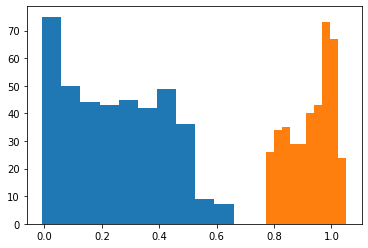

In [3]:
# Data playground:
# Here we experiment with the properties of the dataset, in an attempt to determine the most suitable classifier.

X = labeled_data[:, 0:D]
Y = labeled_data[:, D]

'''
First, check whether we could use PCA. We wil check how many components we need to keep,
in order to maintain 90% of the explained variance.
'''
variance_ratio = 0.9
C = np.cov(X, rowvar=False) # `rowvar=False`: each row of X is a sample
ev = np.linalg.eigvals(C)

total_var = np.sum(ev)
explained_var = 0.0
nc = 0 # number of components to keep
ratio = 0.0

for i in range(D):
    explained_var += ev[i]
    ratio = explained_var / total_var
    if ratio >= variance_ratio:
        nc = i
        print(f" > Number of components : {nc}, explaining {ratio:.3f} of the total variance.")
        break
# The number of components is too high to bother transforming thre data.
# The explained variance is equally distributed amongst almost all features.
# So, we have no concrete way to visualize the data.

'''
Now, we will check whether we can improve our data by scaling, or normalizing it.
We will check the means and variances for all 400 features.
'''
means = np.mean(X, axis=0) # the mean across all columns
plt.hist(means)
plt.hist(np.diag(C))
# There's no scaling that needs to be done, since all features are in the same order of magnitude.

In [16]:
from typing import Tuple

'''
Creating a class like the one used in Question C.
Will be used in order to store information on the hyperparameters
of the model that was considered the best one after an atypical grid search.
'''
class MLP_training_info:
    # Use sklearn's default values.
    def __init__(
        self, *,
        hidden_layer_sizes: Tuple[int] = (100),
        activation: str = "relu",
        solver: str = "adam",
        learning_rate: str = "constant",
        learning_rate_init: float = 0.001,
        tol: float = 1.e-4,
        momentum: float = 0.9
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.tol = tol
        self.momentum = momentum

    def __str__(self):
        s = (f"{self.hidden_layer_sizes}, f={self.activation}, s={self.solver}, "
            f"eta={self.learning_rate_init}|{self.learning_rate}, "
            f"tol={self.tol}, m={self.momentum}")
        return s

In [24]:
def train_mlp(X_train, y_train, info: MLP_training_info) -> MLPClassifier:
    model = MLPClassifier(
        activation=info.activation,
        solver=info.solver,
        learning_rate=info.learning_rate,
        learning_rate_init=info.learning_rate_init,
        tol=info.tol,
        momentum=info.momentum,
        shuffle=False
    )
    model.fit(X_train, y_train)
    return model

def test_params(
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray, y_test: np.ndarray, info: MLP_training_info
):
    model = train_mlp(X_train, y_train, info)
    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_plot = metrics.ConfusionMatrixDisplay(cm)
    cm_plot.plot()
    cm_plot.ax_.set_title(info.__str__())
    print(f"{info}: {metrics.accuracy_score(y_test, y_pred)}")

[600, 266], f=relu, s=lbfgs, eta=0.005|adaptive, tol=0.0001, m=0.9: 0.8096
(200, 200), f=relu, s=lbfgs, eta=0.005|adaptive, tol=0.0001, m=0.9: 0.8068
(200, 200), f=logistic, s=lbfgs, eta=0.005|adaptive, tol=0.0001, m=0.9: 0.8068
(200, 200), f=logistic, s=lbfgs, eta=0.001|adaptive, tol=0.0001, m=0.9: 0.8012
(200, 200), f=logistic, s=lbfgs, eta=0.001|constant, tol=0.0001, m=0.9: 0.7972
(200, 200), f=logistic, s=lbfgs, eta=0.001|invscaling, tol=0.0001, m=0.9: 0.8016
(200, 200), f=tanh, s=lbfgs, eta=0.001|invscaling, tol=0.0001, m=0.9: 0.7828
(200, 200), f=logistic, s=lbfgs, eta=0.001|invscaling, tol=1e-05, m=0.9: 0.8048
400, f=logistic, s=lbfgs, eta=0.001|invscaling, tol=0.005, m=0.95: 0.8192
400, f=relu, s=lbfgs, eta=0.001|invscaling, tol=0.005, m=0.95: 0.802
(200, 400, 200), f=relu, s=lbfgs, eta=0.001|invscaling, tol=0.005, m=0.95: 0.8084
(200, 400, 200), f=relu, s=lbfgs, eta=0.001|adaptive, tol=0.0001, m=0.95: 0.8132
(200, 400, 200), f=logistic, s=lbfgs, eta=0.001|adaptive, tol=0.0001,

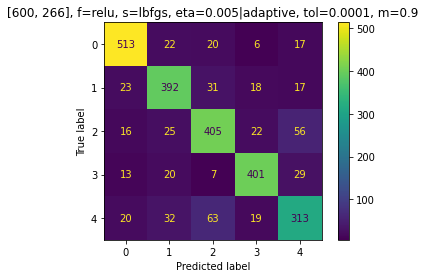

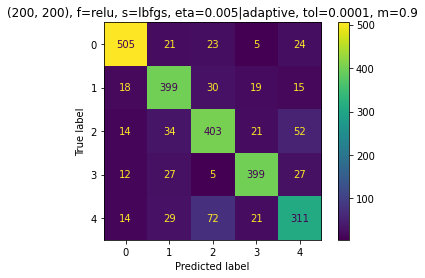

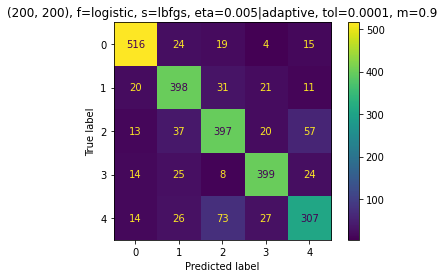

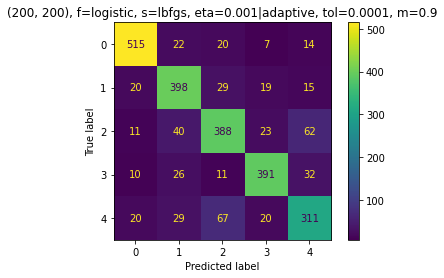

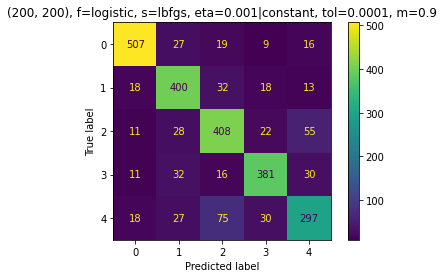

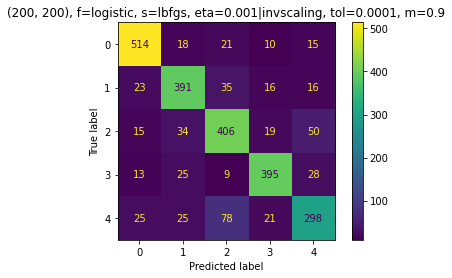

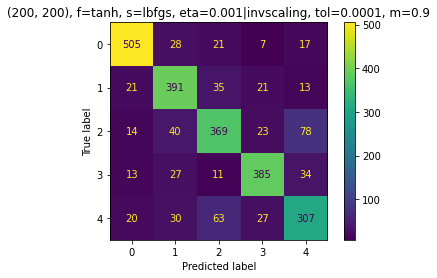

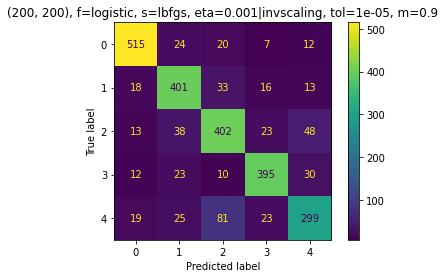

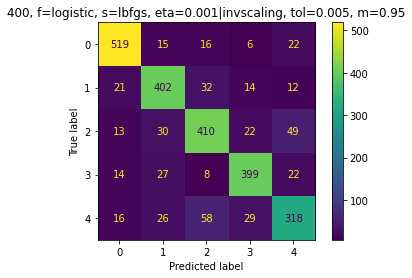

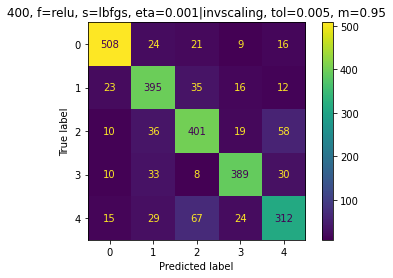

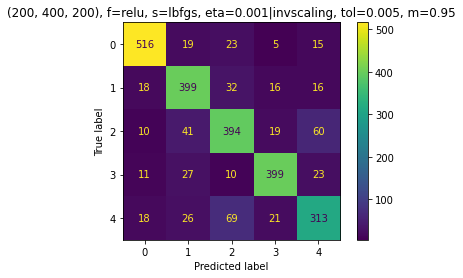

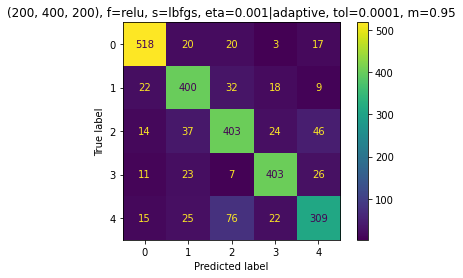

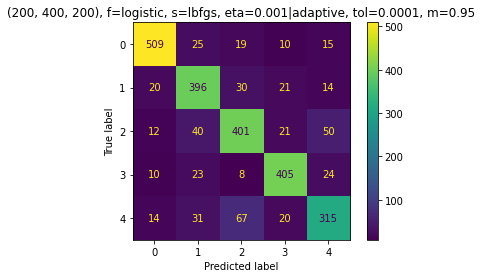

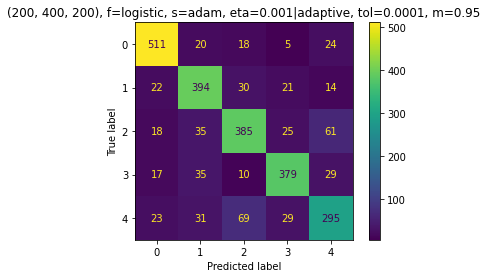

In [41]:
# Split the testing dataset in half.
# First half will remain the testing data, second half will be used for validation.
Nt = int(N_test / 2)
Nv = N_test - Nt
X_testc, y_testc = X_test[:, 0:Nt], y_test[0:Nt]
X_validate, y_validate = X_test[:, Nt:], y_test[Nt:]

best_acc = 0.0

info = MLP_training_info(
    hidden_layer_sizes = [int(3*D/2), int(2*D/3)],
    learning_rate_init = 0.005,
    learning_rate = "adaptive",
    solver = "sgd"
)
# test_params(X_train, y_train, X_test, y_test, info)

info.solver = "lbfgs"
test_params(X_train, y_train, X_test, y_test, info)

info.hidden_layer_sizes = (int(D/2), int(D/2))
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "logistic"
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate_init = 0.001
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate = "constant"
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate = "invscaling"
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "tanh"
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "logistic"
info.tol = 1.e-5
test_params(X_train, y_train, X_test, y_test, info)

info.hidden_layer_sizes = (D)
info.tol = 5.e-3
info.momentum = 0.95
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "relu"
test_params(X_train, y_train, X_test, y_test, info)

info.hidden_layer_sizes = ((int(D/2), D, int(D/2)))
test_params(X_train, y_train, X_test, y_test, info)

info.learning_rate = "adaptive"
info.tol = 1.e-4
test_params(X_train, y_train, X_test, y_test, info)

info.activation = "logistic"
test_params(X_train, y_train, X_test, y_test, info)

info.solver = "adam"
test_params(X_train, y_train, X_test, y_test, info)